# Technical Analysis

## Integrantes:
- Efren Rivera Hernandez
- José Alfonso Martinez Ramirez
- Carola Navarro Badía
- Jose Pablo Vazquez Z

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [2]:
training = pd.read_csv("aapl_1m_train.csv")

In [3]:
training.head(5)

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1672736400,0,2023-01-03 09:00:00,130.28,131.00,130.28,131.00,8174
1,1,1672736460,0,2023-01-03 09:01:00,130.87,131.17,130.87,131.10,8820
2,2,1672736520,0,2023-01-03 09:02:00,131.18,131.24,131.17,131.17,2112
3,3,1672736580,0,2023-01-03 09:03:00,131.19,131.29,131.19,131.28,3888
4,4,1672736640,0,2023-01-03 09:04:00,131.28,131.46,131.28,131.46,5984


In [5]:
test = pd.read_csv("/Users/carolanavarro/Documents/ITESO/8vo semestre/Trading/data/aapl_1m_test.csv")

In [6]:
test.head(5)

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1693555200,0,2023-09-01 08:00:00,188.33,188.54,188.15,188.32,204
1,1,1693555260,0,2023-09-01 08:01:00,188.24,188.47,188.24,188.26,38
2,2,1693555320,0,2023-09-01 08:02:00,188.33,188.36,188.30,188.32,26
3,3,1693555380,0,2023-09-01 08:03:00,188.32,188.34,188.30,188.30,50
4,4,1693555440,0,2023-09-01 08:04:00,188.34,188.35,188.16,188.16,863


In [7]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, 
                 n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

In [ ]:
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [1000000]

for i, row in data.iterrows():

    # Close opearations
    temp_operations= []
    for op in active_operations:
        # Close losing positions
        if op.stop_loss > row.Close:
            cash += row.Close * (1 - com)

        # Close profit
        elif op.take_profit < row.Close: 
            cash += row.Close * (1 - com)

        else:
            temp_operations.append(op)

    active_operations = temp_operations

    # Do we have enough cash?
    if cash > row.Close * (1 + com):

        # buy signal
        if row.Close > row.Open:
            active_operations.append(Operation(operation_type="long",
                                            bought_at=row.Close,
                                                timestamp= row.Timestamp, 
                                                n_shares=1,
                                                stop_loss=row.Close * 0.95,
                                                take_profit=row.Close * 1.05))
            
            cash -= row.Close * (1 + com)

    # Calculate open positions value
    total_value = len(active_operations) * row.Close
    strategy_value.append(cash + total_value)


# Poncho Intento

In [34]:
data = training.copy()

In [35]:
# Convertimos 'Datetime' a datetime para poder calcular las medias móviles
data['Datetime'] = pd.to_datetime(data['Datetime'])


# Calculando indicadores técnicos
# SMA: Simple Moving Average de 20 periodos
data['SMA'] = data['Close'].rolling(window=20).mean()

# EMA: Exponential Moving Average de 20 periodos
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
rolling_mean = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()
data['BBANDS_UpperBand'] = rolling_mean + (rolling_std * 2)
data['BBANDS_LowerBand'] = rolling_mean - (rolling_std * 2)

# MACD (Moving Average Convergence Divergence)
# Nota: Los periodos comunes son 26 para la EMA lenta y 12 para la rápida
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Estocástico
low_min = data['Low'].rolling(window=14).min()
high_max = data['High'].rolling(window=14).max()
data['K'] = ((data['Close'] - low_min) / (high_max - low_min)) * 100
data['D'] = data['K'].rolling(window=3).mean()


In [36]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.stop_loss = stop_loss
        self.take_profit = take_profit

# Variables iniciales
cash = 1000000
active_operations = []
com = 0.00125
strategy_value = [cash]  # Un millón en efectivo

for row in data.itertuples():

    # Cerrar operaciones
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close:  # Cerrar posiciones perdedoras
            cash += op.n_shares * row.Close * (1 - com)
        elif op.take_profit < row.Close:  # Cerrar posiciones con beneficio
            cash += op.n_shares * row.Close * (1 - com)
        else:
            temp_operations.append(op)

    active_operations = temp_operations

    # Comprobar si tenemos suficiente efectivo y condiciones de los indicadores
    if cash > row.Close * (1 + com):
        # Contar cuántas condiciones de compra se cumplen
        conditions_met = sum([
            row.Close > row.SMA,  # Precio sobre la SMA
            row.Close > row.EMA,  # Precio sobre la EMA
            row.Close > row.BBANDS_LowerBand,  # Precio por encima de la banda inferior de Bollinger
            row.D > row.K,  # La línea D del estocástico sobre la línea K
            row.MACD > row.MACD_Signal  # Línea MACD sobre la señal MACD
        ])

        if conditions_met >= 3:  # Cambiado de todas las condiciones a al menos tres
            # Comprar 1 acción como ejemplo
            n_shares = 1  # Definir cuántas acciones comprar basado en alguna lógica
            active_operations.append(Operation(
                operation_type="long",
                bought_at=row.Close,
                timestamp=row.Index,  # Asumiendo que row.Index es el timestamp
                n_shares=n_shares,
                stop_loss=row.Close * 0.97,
                take_profit=row.Close * 1.07
            ))
            cash -= row.Close * n_shares * (1 + com)

    # Calcular el valor de las posiciones abiertas
    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)

# Al final del bucle, convierta la lista de valores de la estrategia en un DataFrame si es necesario
strategy_value_df = pd.DataFrame(strategy_value, columns=['Strategy Value'])

# Suponiendo que quieras unirlo con tu DataFrame 'data' por el índice
final_df = pd.concat([data, strategy_value_df], axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

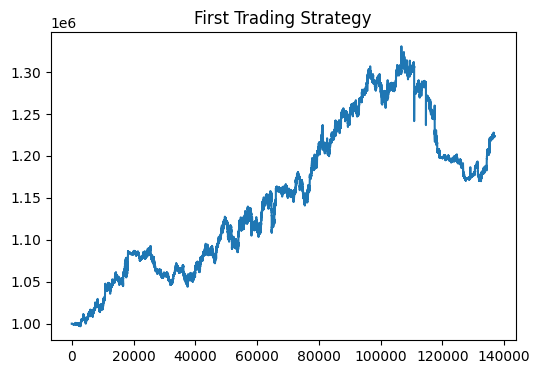

In [38]:
plt.figure(figsize=(6,4))
plt.plot(strategy_value_df)
plt.title("First Trading Strategy")
plt.show

In [28]:
strategy_value_df

,Strategy Value
0,1000000.0
1,1000000.0
2,1000000.0
3,1000000.0
4,1000000.0
...,...
495343,inf
495344,inf
495345,inf
495346,inf
